In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from imutils import face_utils, translate, resize
from imutils.video import VideoStream, FPS, FileVideoStream
import time

from scipy.spatial import distance as dist
import math

In [2]:
def get_lip_thikness(lip):
    thikness = 0
    for i in [2, 3, 4]:
        distance = math.sqrt((lip[i][0] - lip[12-i][0])**2 +
                             (lip[i][1] - lip[12-i][1])**2)
        thikness += distance
    return thikness / 3

def get_mouth_height(top_lip, bottom_lip):
    height = 0
    for i in [8, 9, 10]:
        distance = math.sqrt((top_lip[i][0] - bottom_lip[18-i][0])**2 + 
                             (top_lip[i][1] - bottom_lip[18-i][1])**2)
        height += distance
    return height / 3

def check_mouth_open(top_lip, bottom_lip):
    top_lip_height = get_lip_thikness(top_lip)
    bottom_lip_height = get_lip_thikness(bottom_lip)
    mouth_height = get_mouth_height(top_lip, bottom_lip)

    return mouth_height > min(top_lip_height, bottom_lip_height) * MOUTH_THRESH

In [3]:
def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

def calc_eyes_ratio(leftEye, rightEye):
    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)
    return (leftEAR + rightEAR) / 2.0

In [4]:
def mask_image(frame, shape, face_mask, MASK_NAME):
    dst_points = {'eyes': np.float32([shape[36], shape[45], shape[30]]),
                  'nose': np.float32([shape[30], shape[50], shape[52]]),
                  'brows': np.float32([shape[19], shape[27], shape[24]]),
                  'moustache': np.float32([shape[49], shape[33], shape[53]]),
                  'left_ear': np.float32([shape[2], shape[1], shape[0]]),
                  'lips': np.float32([shape[8], shape[1], shape[15]])}
    
    face_mask_small = face_mask
    gray_mask = cv2.cvtColor(face_mask_small, cv2.COLOR_BGR2GRAY)
    if not mask_info[MASK_NAME]['transparent']:
        ret, mask = cv2.threshold(gray_mask, 230, 255, cv2.THRESH_BINARY_INV)
    else:
        ret, mask = cv2.threshold(gray_mask, 30, 255, cv2.THRESH_BINARY)
    face_mask2 = cv2.bitwise_and(face_mask_small, face_mask_small, mask=mask)

    rows, cols = frame.shape[:2]
    M = cv2.getAffineTransform(mask_info[MASK_NAME]['src_points'],
                               dst_points[mask_info[MASK_NAME]['dst_points']])
    dst = cv2.warpAffine(face_mask2, M, (cols,rows))
    dst_mask = cv2.warpAffine(mask, M, (cols,rows))

    gray_dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    ret, mask_dst = cv2.threshold(dst_mask, 230, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask_dst)

    masked_frame = cv2.bitwise_and(frame, frame, mask=mask_inv)
    masked_dst = cv2.bitwise_and(dst, dst, mask=mask_dst)

    frame = cv2.add(masked_frame, masked_dst)
    
    return frame

In [5]:
def get_lips(shape):
    ulip = np.append(shape[48:55], shape[60:65][::-1], axis=0)
    blip = np.append(shape[54:60], [shape[48]], axis=0)
    blip = np.append(blip, [shape[60]], axis=0)
    blip = np.append(blip, shape[64:68][::-1], axis=0)
    return ulip, blip

In [6]:
def process_rect(frame, gray, rect, ear_cnt, total, cnt):
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    # extract start and end points
    leftEye, rightEye = shape[42:48], shape[36:42]
    ulip, blip = get_lips(shape)

    # calc eyes ratio
    ear = calc_eyes_ratio(leftEye, rightEye)
    if ear < EYE_AR_THRESH:
        ear_cnt += 1
    else:
        if ear_cnt >= EYE_AR_CONSEC_FRAMES:
            total += 1
        ear_cnt = 0

    # print info about eyes
    cv2.putText(frame, "Blinks: {}".format(total), (10, 30),
      cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # if mouth is open, put corona mask
    if check_mouth_open(ulip, blip):
        cnt += 1
        if cnt >= 10:
            frame = mask_image(frame, shape, corona_mask, 'face_mask.jpeg')
    else:
        cnt = 0

    return mask_image(frame, shape, face_mask, MASK_NAME), ear_cnt, total, cnt

In [7]:
mask_info = { 'mask1.jpg': {
                  "src_points": np.float32([[400, 480], [800, 480], [600, 600]]), 
                  "dst_points": 'eyes',
                  "transparent": False},
              'mask2.jpg': {
                  "src_points": np.float32([[270, 400], [680, 400], [470, 550]]),
                  "dst_points": 'eyes',
                  "transparent": False},
              'cat_nose.png': {
                  "src_points": np.float32([[500, 400], [450, 500], [550, 500]]),
                  "dst_points": 'nose',
                  "transparent": True},
              '2_new_year_hat.PNG': {
                  "src_points": np.float32([[250, 750], [400, 850], [550, 750]]),
                  "dst_points": 'brows',
                  "transparent": True},
              'hat.png': {
                  "src_points": np.float32([[150, 620], [250, 644], [350, 620]]),
                  "dst_points": 'brows',
                  "transparent": False},
              'moustache.png': {
                  "src_points": np.float32([[200, 215], [290, 0], [400, 215]]),
                  "dst_points": 'moustache',
                  "transparent": False},
              '1_cat_left_ear.PNG': {
                  "src_points": np.float32([[450, 900], [600, 780], [800, 650]]),
                  "dst_points": 'left_ear',
                  "transparent": True},
              'face_mask.jpeg': {
                  "src_points": np.float32([[120, 185], [35, 55], [185, 55]]),
                  "dst_points": 'lips',
                  "transparent": False}}

In [8]:
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 3
MOUTH_THRESH = 0.9

ear_cnt = cnt = total = 0

In [9]:
image_dir = "images"
video_dir = "videos"
mask_dir = "masks"
result_dir = "results"

IMG_NAME = "face.jpg"
VIDEO_NAME = "Mironova_3rd_pitch.mp4"
MASK_NAME = 'mask1.jpg'

In [10]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

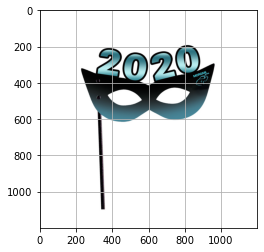

In [11]:
corona_mask = cv2.imread(f"{mask_dir}/face_mask.jpeg")
face_mask = cv2.imread(f"{mask_dir}/{MASK_NAME}")

plt.imshow(face_mask)
plt.grid(True);

In [12]:
target = "v"

In [13]:
if target == "f" or target == "v": 

    if target == "f":
        vs = FileVideoStream(f"{video_dir}/{VIDEO_NAME}").start()
    else:
        vs = VideoStream(src=0).start()
    
    out = cv2.VideoWriter(f"{result_dir}/output.mp4", cv2.VideoWriter_fourcc(*'MP4V'), 
                          30.0, (253, 450), True)
    
    while True:
        if target == "f" and not vs.more():
            break

        frame = vs.read()
        frame = resize(frame, width=450)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)

        for rect in rects:
            frame, ear_cnt, total, cnt = process_rect(frame, gray, rect, ear_cnt, total, cnt)

        cv2.imshow('frame', frame)
    #     out.write(frame_new)

        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    cv2.destroyAllWindows()
    vs.stop()
    out.release()

In [14]:
if target == 'i':
    frame = cv2.imread(f"{image_dir}/{IMG_NAME}")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)

    for rect in rects:
        frame, ear_cnt, total, cnt = process_rect(frame, gray, rect, ear_cnt, total, cnt)

    plt.imshow(frame)
    cv2.imwrite(f"{result_dir}/{IMG_NAME[:-4]}_{MASK_NAME[:-4]}.jpg", frame)